# Data Analysis 1 - CubeData


In [1788]:
import numpy as np
import math as mt 
import scipy.optimize as opt
import scipy.stats as sta
import matplotlib.pyplot as plt
import csv

In [1789]:
def convertF(items):
    ## convert string of measurements to float
    for i,a in enumerate(items):
        if i < 2:   ## start from the 3rd item: x
            continue
        try:
            a=float(a)
        except ValueError:
            return 0    
    return 1
    
def GetEntries(filename):
    #Read the CSV file and import the data into a corresponding list
    ID = []
    cubeNo = []
    meas_x = []
    meas_y = []
    meas_z = []
    meas_v = []
    unc_x = []
    unc_y = []
    unc_z = []
    unc_v = []
    
    with open(filename) as cubedata:
        entries = csv.reader(cubedata, delimiter=',')
        for row in entries:
            ## if there is any invalid entry in a row, then skip this row
            valid_item = convertF(row)
            if not valid_item:
                continue;
                
            ID.append(row[0])
            cubeNo.append(int(row[1]))
            meas_x.append(float(row[2]))
            meas_y.append(float(row[4]))
            meas_z.append(float(row[6]))
            meas_v.append(float(row[8]))
            unc_x.append(float(row[3]))
            unc_y.append(float(row[5]))
            unc_z.append(float(row[7]))
            unc_v.append(float(row[9]))
        
    return ID, cubeNo, meas_x, meas_y, meas_z, meas_v, unc_x, unc_y, unc_z, unc_v

In [1790]:
def calculate_average(values): 
    sumtot = sum(values)
    avg = sumtot / len(values)
    return avg 

def calculate_variance(values):
    avg = calculate_average(values)
    variance = 0
    for val in values:
        variance += (val - avg) ** 2 
    return variance / (len(values) - 1)

def calculate_stdev(values):
    return np.sqrt(calculate_variance(values))


#some other functions
def Incorrect_V(ID,x,y,z,v):
    #Spot out the incorrect calculation of V
    list_incorrection = []
    for i, vi in enumerate(v):
        v_cal = x[i] * y[i] * z[i]
        if mt.fabs(v_cal - vi) > 0.1 * v_cal: ## Pick out cases where reported V deviated from calculated by 10%
            print("{}: {} :\t x={},y={},z={} \t reported V: {} \t calculated V: {:.1f}".format(i,ID[i],x[i],y[i],z[i],v[i],v_cal) )
            list_incorrection.append(i)
    return list_incorrection
            
def gaussian(x,mu,sigma):
    #Python has built-in Norm(Gaussian) function. Anyway we can build our own to compare 
    return (1 / (np.sqrt(2 * np.pi * np.power(sigma, 2)))) * \
    (np.power(np.e, -(np.power((x - mu), 2) / (2 * np.power(sigma, 2)))))

In [1791]:
def plot_distribution(meas,meas_index,FilterOutlier,OutlierIndex,errbar):
    ##meas: the quantity you want to plot
    ##meas_index: quantity index (that's for label), 0--x, 1--y, 2--z, 3--v
    ##FilterOutlier: bool value -- whether to filter out the incorrectly calculated V items
    ##OutlierIndex: the lists of the incorrectly calculated V items
    ##errbar: bool value -- whether to plot error bar
    
    
    ##fisrtly, decide to filter out the outliers/incorrectly calculated V items or not
    lists = list(meas)  # copy the list
    if(FilterOutlier):
        for index in OutlierIndex[::-1]:  ## [::-1] to reverse the list of the outlier index
            del lists[index]


    ## Decide the bin number, bin width, plot range and so on.
    num_bins = int(len(lists) / 20)   ## choose your own
    pltrange = max(lists) - min(lists)
    lower_edge = min(lists) - 0.05 * pltrange
    upper_edge = max(lists) + 0.05 * pltrange
    binwidth = (upper_edge - lower_edge)/num_bins

    ## build up the Gaussian
    avg_lists = calculate_average(lists)
    stdev_lists = calculate_stdev(lists)
    gau_x = np.linspace(lower_edge, upper_edge, 1000)
    gau_y = len(lists)*binwidth*sta.norm.pdf(gau_x,avg_lists,stdev_lists) ## use the built in norm(Gaussian) function
    #gau_y = len(lists)*binwidth*gaussian(gau_x,avg_lists,stdev_lists)    ## Alternative is to use self-defined Gaussian

    ## define the labels
    labels = ["$x$", "$y$", "$z$", "$v$", "$\sigma_x$", "$\sigma_y$", "$\sigma_z$", "$\sigma_v$"]
    units = ''  ##[mm] for x,y,z and their uncertainties; [mm3] for V and its uncertainty
    if meas_index%4 == 3:
        units = "$mm^3$"
    else:
        units = "$mm$"

    labels_x = labels[meas_index] + "[" + units + "]"
    labels_y = "Entries/{:.1f}".format(binwidth) + units
    label_gau = "Gaussian($\mu={:.1f},\sigma={:.1f}$)".format(avg_lists,stdev_lists)


    ##use the custom style
    plt.style.use('mystyle.mplstyle')
    
    ##plot the histograms
    group, nbins, patches= plt.hist(lists, num_bins, color = 'b', label='Measurements', alpha=0.5, range = (lower_edge,upper_edge))

    ## plot error bar
    if errbar:  
        bin_centers = 0.5*(nbins[1:] + nbins[:-1])
        xrr = binwidth/2.0
        yrr = np.sqrt(group)
        plt.errorbar(bin_centers, group, xerr=xrr, yerr=yrr, label='Error',fmt='o')

    ## plot gaussian
    plt.plot(gau_x, gau_y, color = 'r', label=label_gau) ## plot gaussian

    ##title, label and set the x,y range as you like
    plt.ylabel(labels_y,position=(0.1,0.84))
    plt.xlabel(labels_x,position=(0.92,0.1))
    plt.xlim(lower_edge, upper_edge)
    plt.ylim(0, 1.35*group.max())  ## usually plot the upper range of y-axis a little bit larger than the max of the histograms to allow room for legends
    plt.title("Distribution of {}".format(labels[meas_index]))
    plt.grid(True, alpha=0.25) 
    plt.legend(loc='best')

In [1792]:
def plot_CLLevel(meas,meas_index,FilterOutlier,OutlierIndex):
    ##fisrtly, decide to filter out the outliers/incorrectly calculated V items or not
    lists = list(meas)  # copy the list
    if(FilterOutlier):
        for index in OutlierIndex[::-1]:  ## [::-1] to reverse the list of the outlier index
            del lists[index]


    ## Decide the bin number, bin width, plot range and so on.
    num_bins = int(len(lists) / 20)
    pltrange = max(lists) - min(lists)
    lower_edge = min(lists) - 0.05 * pltrange
    upper_edge = max(lists) + 0.05 * pltrange
    binwidth = (upper_edge - lower_edge)/num_bins

    ## build up the Gaussian
    avg_lists = calculate_average(lists)
    stdev_lists = calculate_stdev(lists)
    gau_x = np.linspace(lower_edge, upper_edge, 1000)
    gau_y = len(lists)*binwidth*sta.norm.pdf(gau_x,avg_lists,stdev_lists) ## use the built in norm(Gaussian) function
    
    ## define the labels
    labels = ["$x$", "$y$", "$z$", "$v$", "$\sigma_x$", "$\sigma_y$", "$\sigma_z$", "$\sigma_v$"]
    units = ''  ##[mm] for x,y,z and their uncertainties; [mm3] for V and its uncertainty
    if meas_index%4 == 3:
        units = "$mm^3$"
    else:
        units = "$mm$"

    labels_x = labels[meas_index] + "[" + units + "]"
    labels_y = "Entries/{:.1f}".format(binwidth) + units
    label_gau = "Gaussian($\mu={:.1f},\sigma={:.1f}$)".format(avg_lists,stdev_lists)

    plt.style.use('mystyle.mplstyle')
    
    group, nbins, patches= plt.hist(lists, num_bins,edgecolor='None', facecolor="None", range = (lower_edge,upper_edge), lw=2 )

    bin_centers = 0.5*(nbins[1:] + nbins[:-1])
    xrr = binwidth/2.0
    yrr = np.sqrt(group)
    plt.errorbar(bin_centers, group, xerr=xrr, yerr=yrr, ecolor='black', color='black',label='Measurements',fmt='o')
    
    plt.plot(gau_x, gau_y, color = 'r', label=label_gau)

    ##plot CL
    # 1 sigma    
    s1x = np.linspace(avg_lists - stdev_lists, avg_lists + stdev_lists, 10)
    s1y = len(lists)*binwidth*sta.norm.pdf(s1x, avg_lists, stdev_lists)
    plt.fill_between(s1x, s1y, color='#F96849', label="$1\sigma$", alpha=0.75)

    # 2 sigma
    s2x_h = np.linspace(avg_lists + stdev_lists, avg_lists + 2*stdev_lists, 10)
    s2y = len(lists)*binwidth*sta.norm.pdf(s2x_h, avg_lists, stdev_lists)
    plt.fill_between(s2x_h, s2y, color='#F98167', label="$2\sigma$", alpha=0.75)

    s2x_l = np.linspace(avg_lists - stdev_lists, avg_lists - 2*stdev_lists, 10)
    plt.fill_between(s2x_l, s2y, color='#F98167', alpha=0.75)

    # 3 sigma
    s3x_h = np.linspace(avg_lists + 2*stdev_lists, avg_lists + 3*stdev_lists, 10)
    s3y = len(lists)*binwidth*sta.norm.pdf(s3x_h, avg_lists, stdev_lists)
    plt.fill_between(s3x_h, s3y, color='#F19885', label="$3\sigma$", alpha=0.75)

    s3x_l = np.linspace(avg_lists - 2*stdev_lists, avg_lists - 3*stdev_lists, 10)
    plt.fill_between(s3x_l, s3y, color='#F19885', alpha=0.75)


    #greater than 3 sigma
    s4x_h = np.linspace(avg_lists + 3*stdev_lists, upper_edge, 10)
    s4y = len(lists)*binwidth*sta.norm.pdf(s4x_h, avg_lists, stdev_lists)
    plt.fill_between(s4x_h, s4y, color='#F1B9AD', label="$\geq3\sigma$", alpha=0.75)

    s4x_l = np.linspace(avg_lists - 3*stdev_lists, lower_edge, 10)
    plt.fill_between(s4x_l, s4y, color='#F1B9AD', alpha=0.75)    
    
    plt.ylabel(labels_y,position=(0.1,0.84))
    plt.xlabel(labels_x,position=(0.92,0.1))
    plt.xlim(lower_edge, upper_edge)
    plt.ylim(0, 1.35*group.max())
    plt.title("Distribution of {} with CL".format(labels[meas_index]))
    plt.grid(True, alpha=0.25)
    plt.legend(loc=(0.03,0.65))   ##if the best location doesn't work, just define your own
    #plt.legend(loc='best')

In [1793]:
def plot_2Ddistribution(meas_a, meas_b, meas_index_a, meas_index_b, FilterOutlier, OutlierIndex):

    ##fisrtly, decide to filter out the outliers/incorrectly calculated V items or not
    lists_a = list(meas_a)  # copy the list
    lists_b = list(meas_b)
    if(FilterOutlier):
        for index in OutlierIndex[::-1]:  ## [::-1] to reverse the list of the outlier index
            del lists_a[index]
            del lists_b[index]


    ## Decide the bin number, bin width, plot range and so on.
    num_bins = int(len(lists_a) / 20)
    pltrange_a = max(lists_a) - min(lists_a)
    lower_edge_a = min(lists_a) - 0.05 * pltrange_a
    upper_edge_a = max(lists_a) + 0.05 * pltrange_a
    binwidth_a = (upper_edge_a - lower_edge_a)/num_bins

    pltrange_b = max(lists_b) - min(lists_b)
    lower_edge_b = min(lists_b) - 0.05 * pltrange_b
    upper_edge_b = max(lists_b) + 0.05 * pltrange_b
    binwidth_b = (upper_edge_b - lower_edge_b)/num_bins
    
    ## define the labels
    labels = ["$x [mm]$", "$y [mm]$", "$z [mm]$", "$v [mm^3]$", "$\sigma_x [mm]$", "$\sigma_y [mm]$", "$\sigma_z [mm]$", "$\sigma_v [mm^3]$"]
    titles = ["x","y","z","v","$\sigma_x$","$\sigma_y$","$\sigma_z$","$\sigma_v$"]

    plt.style.use('mystyle.mplstyle')
    #plt.figure(figsize=(8, 6))
    plt.hist2d(lists_a, lists_b, bins=(num_bins, num_bins), cmap=plt.cm.jet)
    
    plt.ylabel(labels[meas_index_b],position=(0.1,0.84))
    plt.xlabel(labels[meas_index_a],position=(0.9,0.1))
    plt.xlim(lower_edge_a, upper_edge_a)
    plt.ylim(lower_edge_b, upper_edge_b)
    plt.title("Correlation between {} and {}".format(titles[meas_index_a],titles[meas_index_b]))
    plt.grid(True, alpha=0.25)
    plt.colorbar()

In [1794]:
ID, cubeNo, meas_x, meas_y, meas_z, meas_v, unc_x, unc_y, unc_z, unc_v = GetEntries("cubeData_new.csv")

print("Mean x: {:.1f}; stdev: {:.1f}".format(calculate_average(meas_x), calculate_stdev(meas_x)))
print("Mean y: {:.1f}; stdev: {:.1f}".format(calculate_average(meas_y), calculate_stdev(meas_y)))
print("Mean z: {:.1f}; stdev: {:.1f}".format(calculate_average(meas_z), calculate_stdev(meas_z)))
print("Mean v: {:.1f}; stdev: {:.1f}".format(calculate_average(meas_v), calculate_stdev(meas_v)))


print("Esitimated mean and its uncertainty:")
print("x = {:.2f} ± {:.2f}".format(calculate_average(meas_x), calculate_stdev(meas_x)/np.sqrt(len(meas_x))))
print("y = {:.2f} ± {:.2f}".format(calculate_average(meas_y), calculate_stdev(meas_y)/np.sqrt(len(meas_y))))
print("z = {:.2f} ± {:.2f}".format(calculate_average(meas_z), calculate_stdev(meas_z)/np.sqrt(len(meas_z))))
print("v = {:.2f} ± {:.2f}".format(calculate_average(meas_v), calculate_stdev(meas_v)/np.sqrt(len(meas_v))))

print("\nIncorrected calculated volumn:")
incorrections = Incorrect_V(ID,meas_x,meas_y,meas_z,meas_v)

Mean x: 9.0; stdev: 0.2
Mean y: 10.3; stdev: 0.3
Mean z: 36.7; stdev: 0.7
Mean v: 3479.6; stdev: 1690.0
Esitimated mean and its uncertainty:
x = 9.02 ± 0.01
y = 10.30 ± 0.02
z = 36.69 ± 0.04
v = 3479.55 ± 88.34

Incorrected calculated volumn:
48: 14.Sep.B04.08 :	 x=9.0,y=10.5,z=36.5 	 reported V: 3950.0 	 calculated V: 3449.2
158: 17.Feb.B01.01 :	 x=9.0,y=10.0,z=36.0 	 reported V: 324.0 	 calculated V: 3240.0
271: 18.Sep.B03.10 :	 x=9.0,y=10.1,z=38.8 	 reported V: 35300.0 	 calculated V: 3526.9
284: 19.Feb.B01.01 :	 x=9.2,y=10.4,z=37.0 	 reported V: 476.56 	 calculated V: 3540.2
292: 19.Feb.B02.02 :	 x=8.0,y=10.0,z=37.0 	 reported V: 3330.0 	 calculated V: 2960.0


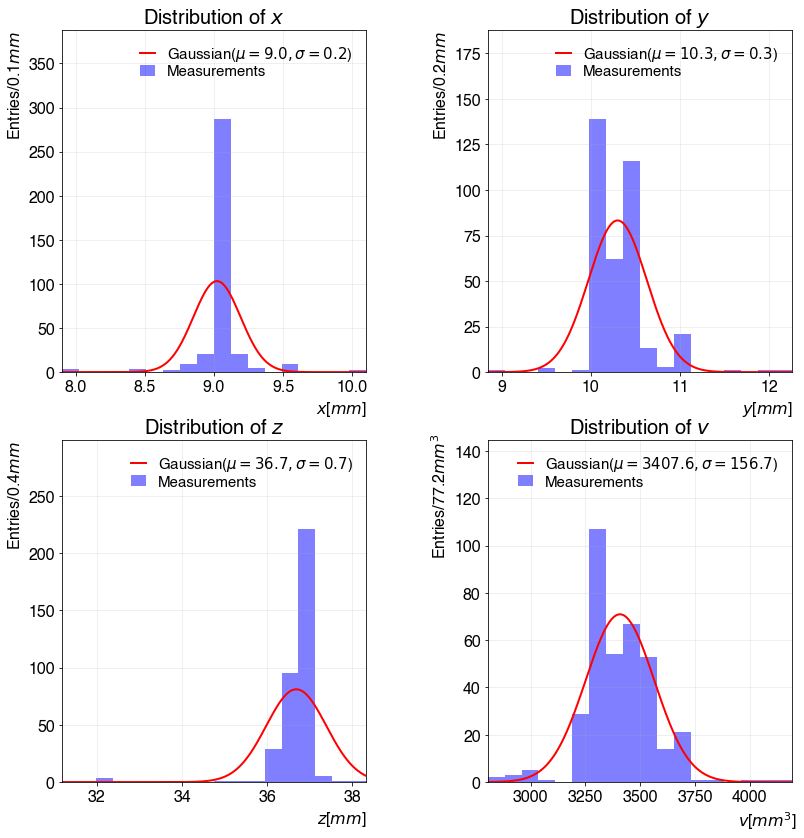

In [1795]:
plt.subplot(2, 2, 1)
plot_distribution(meas_x,0,1,incorrections,0)
plt.subplot(2, 2, 2)
plot_distribution(meas_y,1,1,incorrections,0)
plt.subplot(2, 2, 3)
plot_distribution(meas_z,2,1,incorrections,0)
plt.subplot(2, 2, 4)
plot_distribution(meas_v,3,1,incorrections,0)

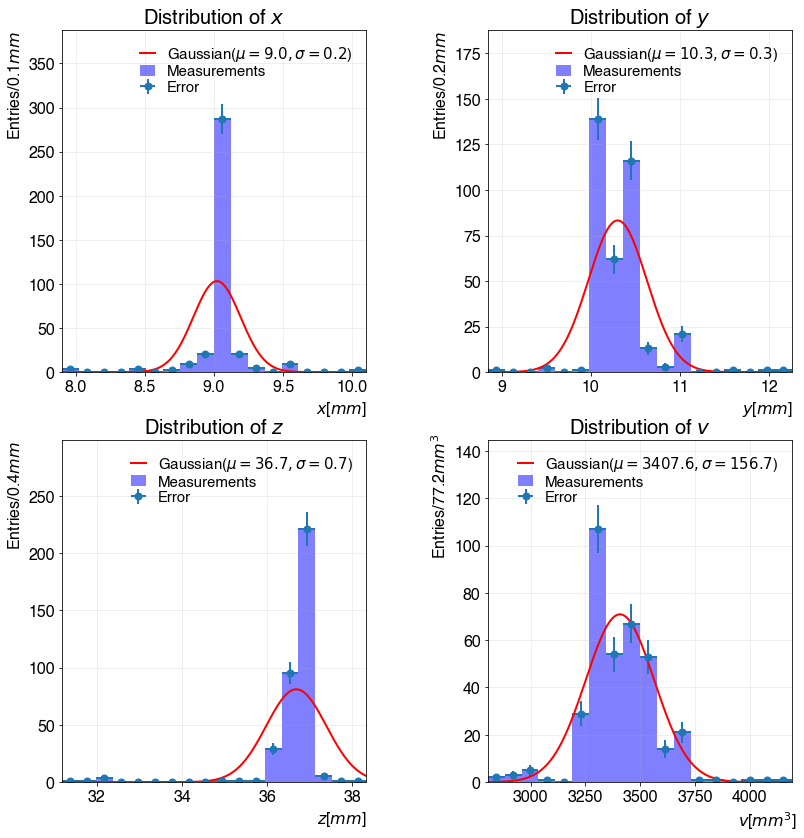

In [1796]:
plt.subplot(2, 2, 1)
plot_distribution(meas_x,0,1,incorrections,1)
plt.subplot(2, 2, 2)
plot_distribution(meas_y,1,1,incorrections,1)
plt.subplot(2, 2, 3)
plot_distribution(meas_z,2,1,incorrections,1)
plt.subplot(2, 2, 4)
plot_distribution(meas_v,3,1,incorrections,1)

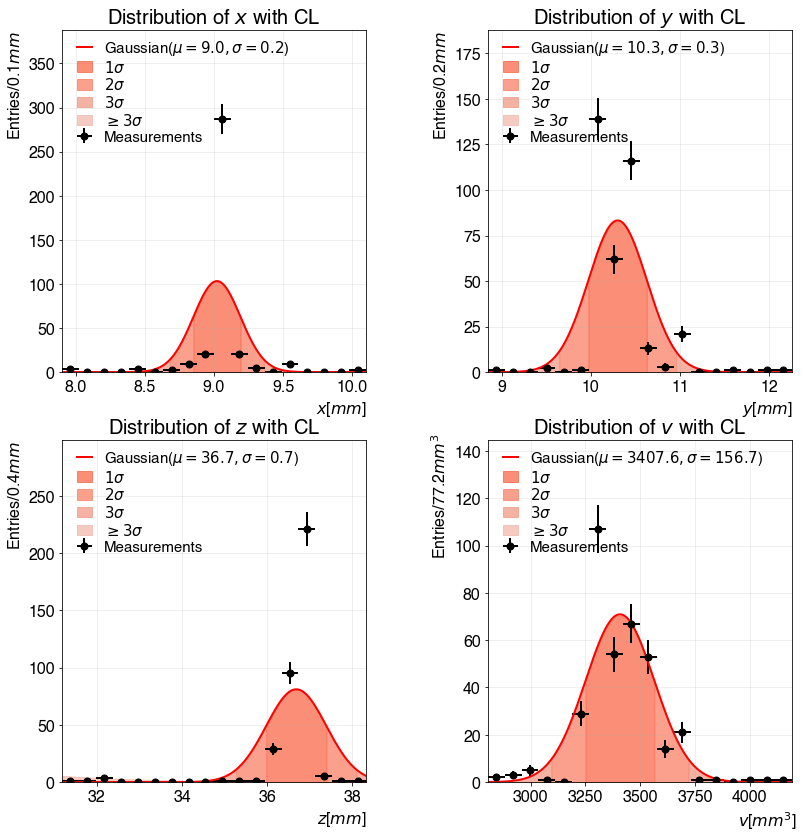

In [1797]:
plt.subplot(2, 2, 1)
plot_CLLevel(meas_x,0,1,incorrections)
plt.subplot(2, 2, 2)
plot_CLLevel(meas_y,1,1,incorrections)
plt.subplot(2, 2, 3)
plot_CLLevel(meas_z,2,1,incorrections)
plt.subplot(2, 2, 4)
plot_CLLevel(meas_v,3,1,incorrections)

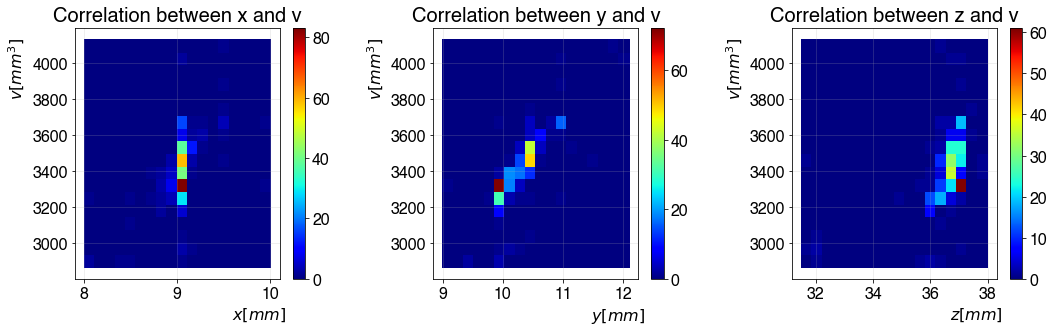

In [1798]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plot_2Ddistribution(meas_x,meas_v,0,3,1,incorrections)
plt.subplot(1, 3, 2)
plot_2Ddistribution(meas_y,meas_v,1,3,1,incorrections)
plt.subplot(1, 3, 3)
plot_2Ddistribution(meas_z,meas_v,2,3,1,incorrections)